# Load the data    

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

BASE_DIR = 'C:\\Users\\Rafael\\Desktop\\EDAN\\P\\lab3\\lab3_eda\\'

df = pd.read_csv(BASE_DIR + 'id-v-microled.csv')
df_1 = pd.read_csv(BASE_DIR + 'micro_led_tb_cadence.csv')

df_2 = df[(df['/I2/p1 Y'] > 10e-9) & (df['/I2/p1 Y'] < 3e-6)]

# Curve fit for obtain current parameters

In [2]:
ut = 0.026

def obtainId2(vgs,Is, vt, n):
    return Is * (np.exp((vgs-vt)/(n*ut)) - 1)

[Is,vt,n], pcov = curve_fit(obtainId2, df_2['/I2/p1 X'], df_2['/I2/p1 Y'], p0=(1e-3,1,1))

print('Is = ', Is)
print('vt = ', vt)
print('n = ', n)

Is =  1.8590268202397832e-18
vt =  1.2200800720116642
n =  1.3239995374285203


# Plot Cadence current characteristic Vs experimental results

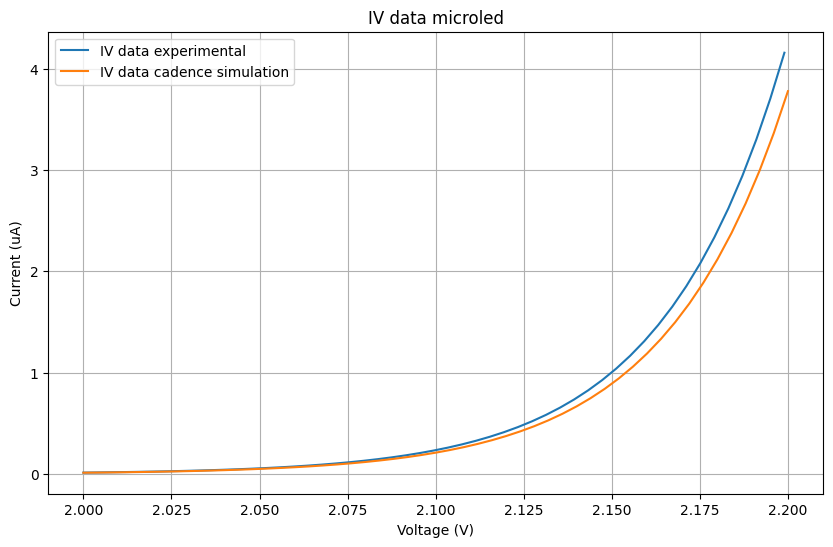

In [3]:
plt.figure(1, figsize=(10, 6))
plt.plot(df['/I2/p1 X'], df['/I2/p1 Y'] * 1e6, label='IV data experimental')
plt.plot(df_1['/I0/i X'], df_1['/I0/i Y'] * 1e6, label='IV data cadence simulation')   
plt.xlabel('Voltage (V)')
plt.ylabel('Current (uA)')
plt.legend(loc='best')
plt.title('IV data microled')
plt.grid()
plt.show()

# TFT current

In [ ]:
def obtainLambda():